# Surface Temperature Forecasting

## About Dataset:

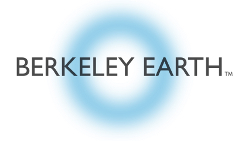

This dataset contains time series data of average surface temperatures of major cities worldwide from the year 1796 upto 2013. This data was taken from Berkeley Earth Data page: http://berkeleyearth.org/data/. 

## Objective:

The objective of this project is to analyse trends in Chennai's surface temperature data and build a forecasting model for the same.

## Cleaning the Data:

### Importing Common Data Handling & Processing Libraries:

In [ ]:
import numpy as np
import pandas as pd

: 

### Importing Data:

In [ ]:
raw_data = pd.read_csv('data/GlobalLandTemperaturesByMajorCity.csv')
raw_data.head()

: 

### Extracting Data:

In [ ]:
chennai_data = raw_data[raw_data.City == 'Madras']
chennai_data.head()

: 

### Setting Date as Index:

In [ ]:
data = chennai_data.copy()

: 

In [ ]:
data['Date'] = pd.to_datetime(data['dt'])

: 

In [ ]:
data.set_index(data['Date'], inplace = True)
data.index

: 

In [ ]:
data.head()

: 

### Dropping Unnecessary Columns:

In [ ]:
cols = ['Date', 'AverageTemperatureUncertainty', 'City', 'Country', 'Latitude', 'Longitude', 'dt']
data.drop(cols, axis = 1, inplace = True)
data.head()

: 

### Extracting Reliable Data:
Prior to the 1970s, temperature readings were taken manually using mercury thermometers where any variation in the visit time impacted measurements. Therefore, we will only use data starting from the 1970s and disregard earlier data as it may not be reliable.

In [ ]:
data = data['1970':'2012']
data.head()

: 

### Checking for Null Values:

In [ ]:
Total = data.isnull().sum().sort_values(ascending = False)          
Percent = (data.isnull().sum()*100/data.isnull().count()).sort_values(ascending = False)   
missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data

: 

## Exploratory Data Analysis:

### Importing Data Visualization Libraries:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

: 

### Visualising the Surface Temperature Data:

In [ ]:
data.plot(figsize = (15, 6), legend = None)
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Temperature', fontsize = 14)
plt.title('Observed Monthly Average Temperature', fontsize = 15)
plt.show()

: 

### Visualising Moving Averages of the Surface Temperatures:

In [ ]:
yearly = data['AverageTemperature'].rolling(window = 12).mean()
fiveyearly = data['AverageTemperature'].rolling(window = 60).mean()
MAax = yearly['1975':].plot(figsize = (15, 6), label = '12-Month Moving Average')
fiveyearly['1975':].plot(ax = MAax, color = 'red', label = '5-Year Moving Average')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Temperature', fontsize = 14)
plt.title('Surface Temperature Moving Averages', fontsize = 15)
plt.legend()
plt.show()

: 

### Seasonal Decomposition using Moving Averages:

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

#Decomposing the time series:
decomposition = seasonal_decompose(data)

#Plotting the observed values:
observed = decomposition.observed
plt.figure(figsize = (15, 4))
plt.plot(observed, label = 'Observed')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Monthly Average', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Observed Data", fontsize = 15)
plt.show()

#Plotting the trend component:
trend = decomposition.trend
plt.figure(figsize = (15, 4))
plt.plot(trend, label = 'Trend', color = 'green')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('7-Month Moving Average', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Trend Component", fontsize = 15)
plt.show()

#Plotting the seasonal component:
seasonal = decomposition.seasonal
plt.figure(figsize = (15, 4))
plt.plot(seasonal, label = 'Seasonal', color = 'yellow')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('Monthly Average (De-trended)', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Seasonal Component", fontsize = 15)
plt.show()

#Plotting the residual component:
residual = decomposition.resid
plt.figure(figsize = (15, 4))
plt.plot(residual, label = 'Residual', color = 'red')
plt.xlabel('Date', fontsize = 14)
plt.ylabel('7-Month Moving Average (Residuals)', fontsize = 14)
plt.legend(loc = 'best')
plt.title("Residual Component", fontsize = 15)
plt.show()

: 

### Checking for Stationarity of Data:
A stationary process has the property that the mean, variance and autocorrelation structure do not change over time. We need to ensure that the time series is stationary before using it to train a model.

#### Augmented Dickey-Fuller (ADF) Test:
* Augmented Dickey-Fuller (ADF) statistics is one of the more widely used statistical test to check whether the time series is stationary or non-stationary. 
* It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

**Null Hypothesis:** Series is not stationary.  
**Alternate Hypothesis:** Series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','No. of Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
adf_test(data)

: 

The p-value is lesser than the level of significance (0.05) and hence it is strong evidence against the null hypothesis and therefore we reject the null hypothesis. **This indicates that our time series data is stationary**.

#### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

KPSS (Kwiatkowski-Philips-Schmidt-Shin) test is a statistical test to check for stationarity of a series around a deterministic trend.
KPSS  test figures out if a time series is stationary around a mean or linear trend or is non-stationary due to a unit root.

**Null Hypothesis:** The series is trend stationary.  
**Alternate Hypothesis:** The series is not stationary.

In [ ]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression = 'c', nlags = 'legacy')
    kpss_output = pd.Series(kpsstest[0:3], index = ['Test Statistic','p-value','No. of Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
kpss_test(data)

: 

The p-value is greater than the level of significance (0.05) and hence it is weak evidence against the null hypothesis and therefore we fail to reject the null hypothesis. **This indicates that our time series is stationary.**

**Both ADF and KPSS tests are in agreement that the time series data is stationary.**

## Pre-processing the Data:

### Assigning Frequency to the Time Series Data:

We resample the data with 'MS' (Month Start) as the frequency. Although the data already consisted of only monthly samples, resampling it this way assigns a frequency to it. Frequency ambiguity could lead to the SARIMAX model auto-assigning the frequency which should be avoided.

In [ ]:
y = data['AverageTemperature'].resample('MS').mean()
y.head()

: 

### Creating Train and Test Splits:

In [ ]:
train = y[:'2009']
test = y['2010':]

: 

## The Autoregressive Integrated Moving Average (ARIMA) Model:

Autoregressive Integrated Moving Average (ARIMA) is a model used in statistics and econometrics to measure events that happen over a period of time. The model is used to understand past data or predict future data in a series.

 - AR (Autoregression) : Model that shows a changing variable that regresses on its own lagged/prior values.
 - I (Integrated) : Differencing of raw observations to allow for the time series to become stationary
 - MA (Moving average) : Dependency between an observation and a residual error from a moving average model

For ARIMA models, a standard notation would be ARIMA with p, d, and q, where integer values substitute for the parameters to indicate the type of ARIMA model used.

 - p: the number of lag observations in the model; also known as the lag order.
 - d: the number of times that the raw observations are differenced; also known as the degree of differencing.
 - q: the size of the moving average window; also known as the order of the moving average.

## Seasonal Autoregressive Integrated Moving Average (SARIMA):

As we previously noticed, there's a seasonal component present in our data and therefore we'll be using Seasonal ARIMA.
Seasonal ARIMA is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component. It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

 - P: Seasonal autoregressive order.
 - D: Seasonal difference order.
 - Q: Seasonal moving average order.
 - m: The number of time steps for a single seasonal period.

## Building the SARIMAX Model:

### Using Auto-ARIMA to Find Optimal Values of the Hyperparameters:
The auto-ARIMA process seeks to identify the most optimal parameters for an ARIMA model, settling on a single fitted ARIMA model.

In [ ]:
##### PMDARIMA LIBRARY DOES NOT WORK ON KAGGLE. RUN THIS CODE LOCALLY OR REFER THE NEXT CODE BLOCK FOR THE OPTIMAL HYPERPARAMETERS. #####

"""
from pmdarima.arima import auto_arima

#The default values of several important parameters for auto_arima function are as follows:
#max_p=5, max_d=2, max_q=5, max_P=2, max_D=1, max_Q=2

arima_model = auto_arima(train, seasonal = True, m = 12, stepwise = False, trace = 1, random_state = 10)
"""

: 

In [ ]:
#
test=train[-12:]
train=train[:-12]

: 

### Training the SARIMAX Model:
Now we train the SARIMAX model using the optimal values of the hyperparameters that we found using auto-ARIMA.

In [ ]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train, order = (1, 0, 0), seasonal_order = (1, 0, 1, 12), 
                                  enforce_stationarity = False, enforce_invertibility = False)
fitted_model = model.fit(maxiter = 200, method = 'nm')
print(fitted_model.summary())

: 

### Plotting Diagnostics of the Data:
Diagnostic plots for standardized residuals of the surface temperatures.  

The plot_diagnostics function produces a 2x2 plot grid with the following plots (ordered clockwise from top left):
* Standardized residuals over time
* Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference.
* Normal Q-Q plot, with Normal reference line.
* Correlogram

In [ ]:
fitted_model.plot_diagnostics(figsize = (15, 12))
plt.show()

: 

**As seen through the histogram and the Normal Q-Q, the residuals are normally distributed and the correlogram confirms that there's insignificant autocorrelation present in the residuals.**

## SARIMAX Forecasting:

In [ ]:
#Getting the SARIMAX forecast with number of steps as 36 since we want to make 3 year prediction and our data is monthly sampled.
pred = fitted_model.get_forecast(steps = 36)
#Plotting the observed and forecasted values:
ax1 = y['2000':].plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax1, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
#Finding the confidence intervals of the forecasts.
pred_ci = pred.conf_int()
ax1.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Temperature')
plt.legend(loc = 'upper left')
plt.show()

: 

### Zooming In on the Forecast:

In [ ]:
#Plotting the observed and forecasted values:
ax2 = y['2010':].plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax2, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
#Finding the confidence intervals of the forecasts.
pred_ci = pred.conf_int()
ax2.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Temperature')
plt.legend()
plt.show()

: 

## Evaluating the SARIMAX Model:

In [ ]:
y_forecasted_SARIMAX = pred.predicted_mean
y_truth = test
mse_SARIMAX = ((y_forecasted_SARIMAX - y_truth) ** 2).mean()
print('The Mean Squared Error of SARIMAX forecast is {}'.format(round(mse_SARIMAX, 2)))
print('The Root Mean Squared Error of SARIMAX forecast is {}'.format(round(np.sqrt(mse_SARIMAX), 2)))

: 

**The RMSE tells us that the SARIMAX model was able to forecast the monthly average temperature within 0.62°C of the true temperature.**

In [ ]:
import pickle
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.statespace import sarimax
from datetime import datetime
import requests
from io import BytesIO

: 

In [ ]:
outfile = open("SARIMAX_model_test.pickle","wb")
pickle.dump(model,outfile)
outfile.close()

: 

In [ ]:
fitted_model.save("test.pickle")

: 

: 

# Load the model and forecast next 36 months

In [ ]:
with open("SARIMAX_model_test.pickle","rb") as f:
    SARIMAX_model = pickle.load(f)

res = sarimax.SARIMAXResultsWrapper.load("test.pickle")
pred_uc = res.get_forecast(steps = 36)
pred_uc.predicted_mean

: 

: 

: 

In [ ]:
pred_uc.conf_int()


: 

In [ ]:
future_df = pd.DataFrame({'pred' : pred_uc.predicted_mean})

: 

In [ ]:
test

: 

In [ ]:
future_df

: 

In [ ]:

print('Forecast:')
#print(future_df)


plt.rcParams["figure.figsize"] = (8, 5)

plt.plot(test, color = 'blue', label = 'Actual')
plt.plot(future_df['pred'], color = 'orange',label = 'Predicted')
plt.show()

: 

: 

: 